# 이항분류 모듈화, 파라미터 튜닝

> 피마 인디언 당뇨병 데이터

## #01. 준비작업

### [1] 패키지 가져오기


In [10]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action="ignore")

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기


In [11]:
origin = my_read_excel(
    "https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=["Outcome"]
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB
None

상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThi

## #02. 데이터 전처리

### [1] 이전 예제에서 수립한 전처리 전략 재현

0값을 포함해서는 안되는 변수에 대해 평균으로 대체


In [12]:
# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# `0`값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

### [2] 데이터 표준화


In [13]:
df3 = my_minmax_scaler(df2, "Outcome")
df3

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.170130,0.314928,0.234415,0.483333,1.0
1,0.058824,0.264516,0.428571,0.239130,0.170130,0.171779,0.116567,0.166667,0.0
2,0.470588,0.896774,0.408163,0.240798,0.170130,0.104294,0.253629,0.183333,1.0
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0.0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1.0
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.445652,0.199519,0.300613,0.039710,0.700000,0.0
764,0.117647,0.503226,0.469388,0.217391,0.170130,0.380368,0.111870,0.100000,0.0
765,0.294118,0.496774,0.489796,0.173913,0.117788,0.163599,0.071307,0.150000,0.0
766,0.058824,0.529032,0.367347,0.240798,0.170130,0.243354,0.115713,0.433333,1.0


### [3] 종속변수 라벨링


In [14]:
df4 = my_labelling(df3, "Outcome")
df4

+-----------+---------+
|   Outcome |   label |
|-----------+---------|
|         0 |       0 |
|         1 |       1 |
+-----------+---------+


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.670968,0.489796,0.304348,0.170130,0.314928,0.234415,0.483333,1
1,0.058824,0.264516,0.428571,0.239130,0.170130,0.171779,0.116567,0.166667,0
2,0.470588,0.896774,0.408163,0.240798,0.170130,0.104294,0.253629,0.183333,1
3,0.058824,0.290323,0.428571,0.173913,0.096154,0.202454,0.038002,0.000000,0
4,0.000000,0.600000,0.163265,0.304348,0.185096,0.509202,0.943638,0.200000,1
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.367742,0.530612,0.445652,0.199519,0.300613,0.039710,0.700000,0
764,0.117647,0.503226,0.469388,0.217391,0.170130,0.380368,0.111870,0.100000,0
765,0.294118,0.496774,0.489796,0.173913,0.117788,0.163599,0.071307,0.150000,0
766,0.058824,0.529032,0.367347,0.240798,0.170130,0.243354,0.115713,0.433333,1


### [4] 훈련, 검증 데이터 분리


In [15]:
x_train, x_test, y_train, y_test = my_train_test_split(
    df4, yname="Outcome", test_size=0.2, scalling=False
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #03. 학습 모델 적합

### [1] 기본 학습


+-------+----------+----------+
|       |      acc |     loss |
|-------+----------+----------|
| train | 0.778502 | 0.450321 |
| test  | 0.779221 | 0.411028 |
+-------+----------+----------+


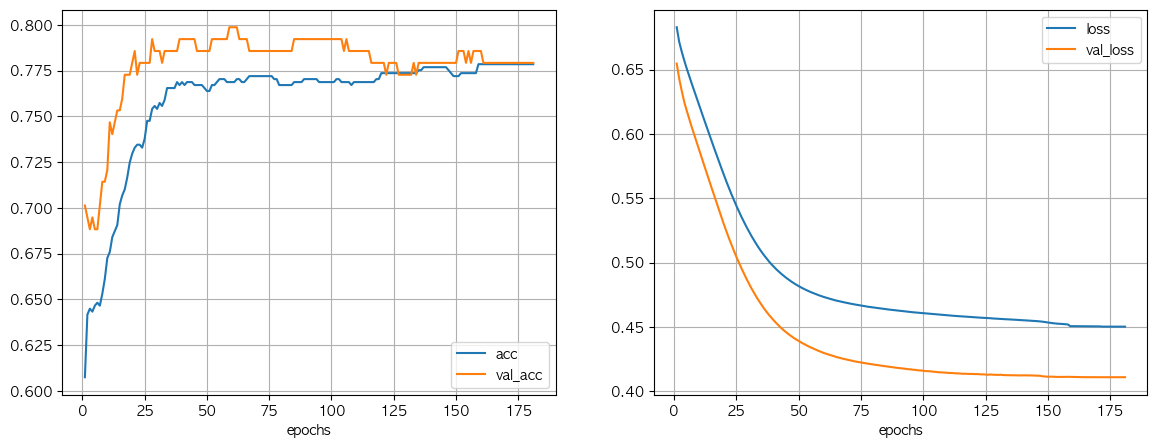

In [16]:
model = my_tf(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    layer=[
        {"units": 32, "activation": "relu", "input_shape": (x_train.shape[1],)},
        {"units": 1, "activation": "sigmoid"},
    ],
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["acc"],
)

### [2] 하이퍼파라미터 튜닝


Trial 9 Complete [00h 00m 01s]
val_acc: 0.7597402334213257

Best val_acc So Far: 0.7727272510528564
Total elapsed time: 00h 00m 13s
+-------+----------+----------+
|       |      acc |     loss |
|-------+----------+----------|
| train | 0.786645 | 0.436259 |
| test  | 0.772727 |  0.41155 |
+-------+----------+----------+


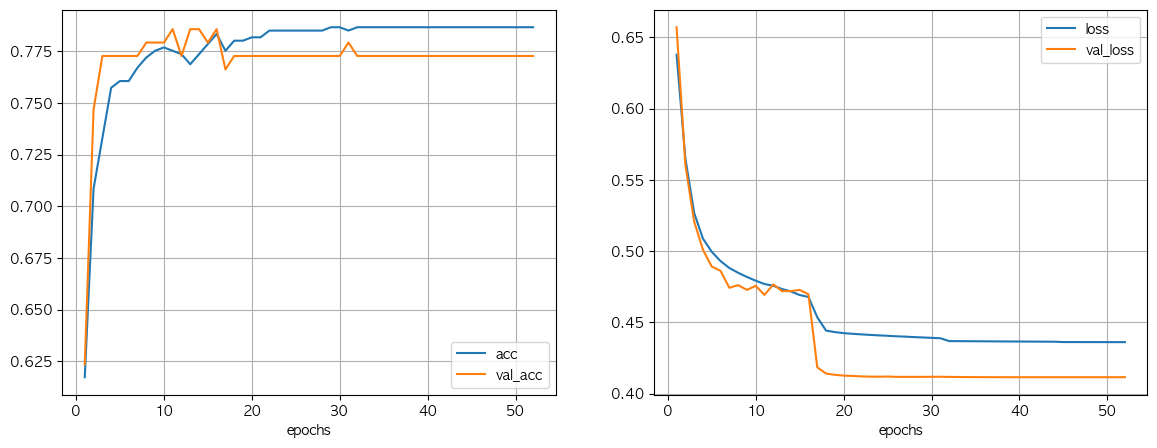

In [17]:
model = my_tf(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    layer=[
        {
            "units": [128, 64, 32],
            "activation": "relu",
            "input_shape": (x_train.shape[1],),
        },
        {"units": 1, "activation": "sigmoid"},
    ],
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["acc"],
    tune=True,
)

### [2] 이진 분류 전용 함수


Trial 11 Complete [00h 00m 01s]
val_acc: 0.7142857313156128

Best val_acc So Far: 0.7727272510528564
Total elapsed time: 00h 00m 15s
+-------+----------+----------+
|       |      acc |     loss |
|-------+----------+----------|
| train | 0.786645 | 0.436259 |
| test  | 0.772727 |  0.41155 |
+-------+----------+----------+


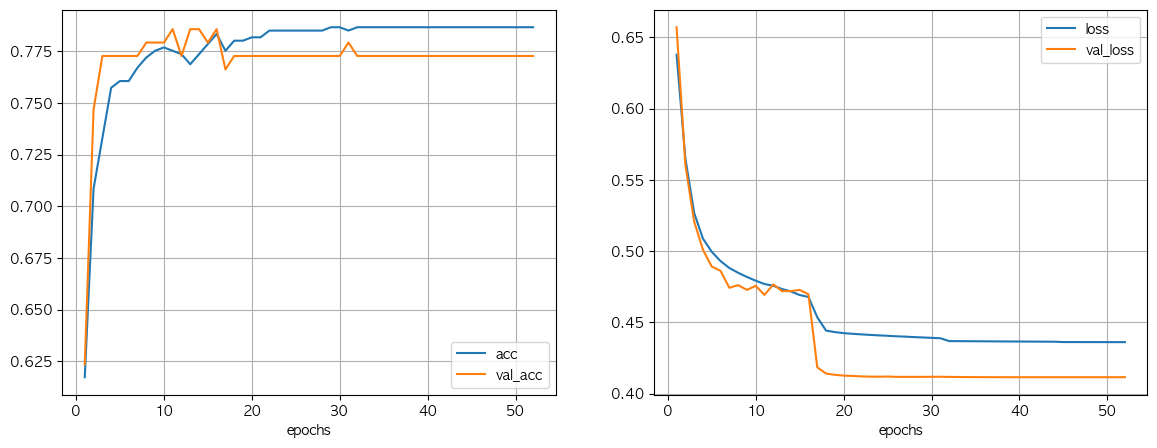

In [18]:
model = my_tf_sigmoid(x_train, y_train, x_test, y_test)